In [1]:
import gymnasium as gym
import torch
import numpy as np
import random
from collections import deque
from IPython import embed
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [48]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
batch_size = 32
n_episodes = 1000

In [49]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Could use Sequential
        self.layer_1 = torch.nn.Linear(state_size, 24)
        self.layer_2 = torch.nn.Linear(24, 24)
        self.layer_3 = torch.nn.Linear(24, action_size)

    def forward(self, x):
        x = np.reshape(x, [1, state_size])
        x = torch.from_numpy(x)
        x = torch.nn.functional.relu(self.layer_1(x))
        x = torch.nn.functional.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

In [50]:
class DQNAgent:
    def __init__(self, state_size, action_size, model):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)

        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

        self.learning_rate = 0.001

        LEARNING_RATE = 0.001
        self.model = model
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state)[0])
            output = self.model(state)
            target_output = torch.clone(output)
            target_output[0][action] = target
            self.optimizer.zero_grad()
            loss = self.criterion(output, target_output)
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [51]:
def eval(env, agent):
    env.reset()
    episode_lengths = []
    for e in range(10):
        state = env.reset()[0]
        done = False
        counter = 0
        while not done:
            action = agent.act(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            state = next_state
            counter += 1
        episode_lengths.append(counter)
    return np.mean(episode_lengths)

episode: 0/1000, score: 42, e: 1.0
episode: 1/1000, score: 8, e: 0.995
episode: 2/1000, score: 23, e: 0.990025
episode: 3/1000, score: 11, e: 0.985074875
episode: 4/1000, score: 15, e: 0.9801495006250001
episode: 5/1000, score: 39, e: 0.9752487531218751
episode: 6/1000, score: 10, e: 0.9703725093562657
episode: 7/1000, score: 10, e: 0.9655206468094844
episode: 8/1000, score: 29, e: 0.960693043575437
episode: 9/1000, score: 12, e: 0.9558895783575597
episode: 10/1000, score: 14, e: 0.9511101304657719
episode: 11/1000, score: 17, e: 0.946354579813443
episode: 12/1000, score: 11, e: 0.9416228069143757
episode: 13/1000, score: 25, e: 0.9369146928798039
episode: 14/1000, score: 19, e: 0.9322301194154049
episode: 15/1000, score: 10, e: 0.9275689688183278
episode: 16/1000, score: 20, e: 0.9229311239742362
episode: 17/1000, score: 32, e: 0.918316468354365
episode: 18/1000, score: 10, e: 0.9137248860125932
episode: 19/1000, score: 15, e: 0.9091562615825302
episode: 20/1000, score: 29, e: 0.90461

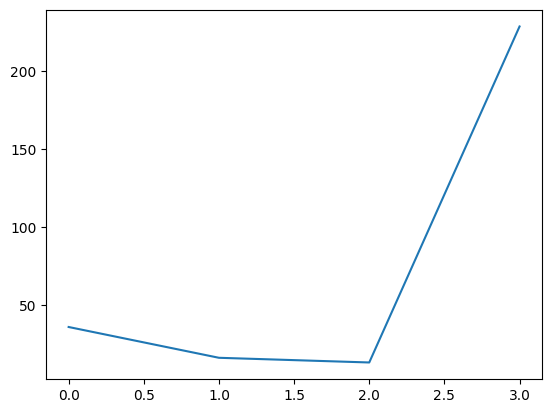

In [59]:
model = Net()
agent = DQNAgent(state_size, action_size, model)
done = False
evaluations = []
for e in range(n_episodes):
    state = env.reset()[0]
    for time in range(5000):
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        reward = reward if not done else -10
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e}/{n_episodes}, score: {time}, e: {agent.epsilon}")
            break
    if e % 100 == 0:
        val = eval(env, agent)
        evaluations.append(val)
        if val > 200:
            break

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

plt.plot(evaluations)
plt.show()

KeyboardInterrupt: 

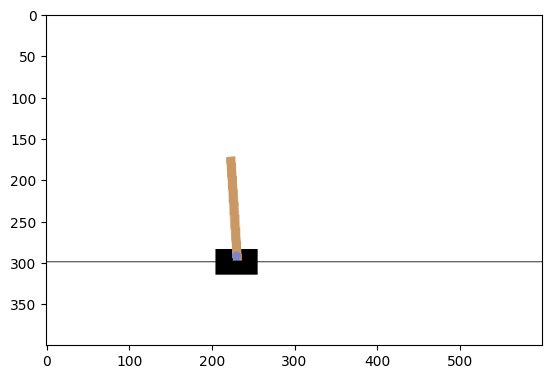

In [61]:
env.reset()
img = plt.imshow(env.render())
episode_lengths = []
for e in range(10):
    state = env.reset()[0]
    done = False
    counter = 0
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        img.set_data(env.render()) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        counter += 1
    episode_lengths.append(counter)
print(f"All episode lengths: {episode_lengths}")
print(f"Average episode length: {np.mean(episode_lengths)}")
env.close()